<div align=center>

# Principles of Simulation:<br />Final Project

By Hamed Araab & Shahriar Khalvati

</div>


## Prerequisites


In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from __future__ import annotations
from framework import *

In [2]:
SPLITS: List[Split] = ["warmup", "main"]
PRIORITIES: List[Priority] = ["low", "high"]
STAGES: List[Stage] = ["examination", "treatment"]
RUNS = 50

Split = Literal["warmup", "main"]
Priority = Literal["low", "high"]
Stage = Literal["examination", "treatment"]
Availability = Literal["busy", "available"]

## Visualizer

In order to run again, restart the notebook to remove variables.


In [3]:
import threading
import eel


def run_eel():
    eel.init("Visualizer")
    eel.start("index.html", mode=None, port=8080)

eel_thread = threading.Thread(target=run_eel)
eel_thread.start()

print("Eel server is running in a separate thread.")

Eel server is running in a separate thread.


In [4]:
# eel.initVisualizer(2, 4)

## Simulator

### Patients


In [5]:
class Patient:
    def __init__(self, id: str) -> None:
        self.id = id
        self.doctor: Dict[Stage, Doctor] = {}
        self.arrivalTime: Dict[Stage, float] = {}
        self.serviceDuration: Dict[Stage, float] = {}
        self.departureTime: Dict[Stage, float] = {}
        self.priority: Priority

    def getWaitingDuration(self, stage: Stage) -> float:
        return (
            self.departureTime[stage]
            - self.serviceDuration[stage]
            - self.arrivalTime[stage]
        )

    @property
    def totalWaitingDuration(self) -> float:
        return sum(self.getWaitingDuration(stage) for stage in STAGES)

    @property
    def totalDuration(self) -> float:
        return self.departureTime["treatment"] - self.arrivalTime["examination"]


class HighPriorityPatient(Patient):
    def __init__(self, id: str) -> None:
        super().__init__(id)

        self.priority = "high"


class LowPriorityPatient(Patient):
    def __init__(self, id: str) -> None:
        super().__init__(id)

        self.priority = "low"

### Doctors


In [6]:
class Doctor:
    def __init__(self, id: str, controller: HospitalController) -> None:
        self.stage: Stage

        self.id = id
        self.status: Availability = "available"
        self.controller = controller

    def getPatients(self, split: Split) -> List[Patient]:
        return [
            patient
            for patient in self.controller.treatedPatients[split]
            if patient.doctor[self.stage] == self
        ]

    def getUtilizationTime(self, split: Split) -> float:
        return sum(
            patient.serviceDuration[self.stage] for patient in self.getPatients(split)
        )


class Examiner(Doctor):
    def __init__(self, id: str, controller: HospitalController) -> None:
        super().__init__(id, controller)

        self.stage = "examination"


class Physician(Doctor):
    def __init__(self, id: str, controller: HospitalController) -> None:
        super().__init__(id, controller)

        self.stage = "treatment"

### Doctor Selection


In [7]:
class DoctorSelection:
    @staticmethod
    def random(doctors: List[Doctor]) -> Doctor:
        doctors = doctors.copy()
        selectedDoctor: Doctor | None = None

        random.shuffle(doctors)

        for doctor in doctors:
            if doctor.status == "available":
                selectedDoctor = doctor

                break

        return selectedDoctor

### Queue


In [8]:
class Queue[T]:
    def __init__(self, controller: SimController) -> None:
        self.meanLength = 0
        self.maxLength = 0
        self.list: List[T] = []
        self.controller = controller

    @property
    def isEmpty(self):
        return self.length == 0

    @property
    def length(self):
        return len(self.list)

    def _updateMean(self, oldLength: int, interval: float):
        clock = self.controller.clock
        prevClock = clock - interval

        if clock != 0:
            self.meanLength = (
                self.meanLength * prevClock + oldLength * interval
            ) / clock

    def push(self, value: T, interval: float):
        self.list.append(value)

        if self.length > self.maxLength:
            self.maxLength += 1

        self._updateMean(self.length - 1, interval)

    def pop(self, interval: float):
        removed = self.list.pop(0)

        self._updateMean(self.length + 1, interval)

        return removed

### Controller


In [9]:
class HospitalController(SimController):
    def __init__(
        self,
        examinersCount=1,
        physiciansCount=1,
        warmupDuration=2 * 24 * 60,
        animate: float | None=None,
    ) -> None:
        super().__init__(stopTime=32 * 24 * 60, initialEvent=ArrivalEvent(initial=True), animate=animate)

        self.treatedPatients: Dict[Split, List[Patient]] = {
            split: [] for split in SPLITS
        }

        self.queue: Dict[str, Queue] = {
            name: Queue(controller=self)
            for name in ["examination_high", "examination_low", "treatment"]
        }

        self.warmupDuration = warmupDuration

        self.examiners = [
            Examiner(id=f"de{i}", controller=self) for i in range(1, examinersCount + 1)
        ]

        self.physicians = [
            Physician(id=f"dp{i}", controller=self) for i in range(1, physiciansCount + 1)
        ]

    def simulate(self) -> Tuple[Dict[str, float]]:
        if self.animate:
            eel.initVisualizer(len(self.examiners), len(self.physicians))

        super().simulate()     

        def avgUP(doctors: List[Doctor], split: Split) -> float:
            return sum(doctor.getUtilizationTime(split) for doctor in doctors) / (
                len(doctors)
                * (
                    self.clock - self.warmupDuration
                    if split == "main"
                    else self.warmupDuration
                )
            )

        def priorityMatches(patient: Patient, queueName: str):
            return (
                patient.priority == queueName.split("_")[1]
                if "_" in queueName
                else True
            )

        def waitingDurationMatches(
            patient: Patient, queueName: str, low: float, high: float
        ):
            return low < patient.getWaitingDuration(queueName.split("_")[0]) <= high

        def waitingDurationPercentage(
            split: Split, queueName: str, low: float, high: float
        ):
            return len(
                [
                    patient
                    for patient in self.treatedPatients[split]
                    if priorityMatches(patient, queueName)
                    and waitingDurationMatches(patient, queueName, low, high)
                ]
            ) / len(
                [
                    patient
                    for patient in self.treatedPatients[split]
                    if priorityMatches(patient, queueName)
                ]
            )

        results = {}

        for split in SPLITS:
            splitResults = {}
            results[split] = splitResults

            splitResults["avgUtil%_exam"] = avgUP(self.examiners, split)
            splitResults["avgUtil%_phys"] = avgUP(self.physicians, split)

            splitResults["totalPatients"] = len(self.treatedPatients[split])

            splitResults["avgWait%"] = sum(
                patient.totalWaitingDuration for patient in self.treatedPatients[split]
            ) / sum(patient.totalDuration for patient in self.treatedPatients[split])

            for queueName, queue in self.queue.items():
                splitResults[f"maxLen_{queueName}"] = queue.maxLength
                splitResults[f"meanLen_{queueName}"] = queue.meanLength

                splitResults[f"zeroWaitTime%_{queueName}"] = waitingDurationPercentage(
                    split,
                    queueName,
                    low=float("-inf"),
                    high=0,
                )

                splitResults[f"lowWaitTime%_{queueName}"] = waitingDurationPercentage(
                    split,
                    queueName,
                    low=0,
                    high=4,
                )

        return results

### Events


#### Arrival


In [10]:
ARRIVAL_EVENT_INTERVAL: Callable[[], float] | None = None


class ArrivalEvent(SimEvent[HospitalController]):
    def __init__(self, initial: bool = False) -> None:
        super().__init__(interval=0 if initial else ARRIVAL_EVENT_INTERVAL())

        rand = random.random()

        self.patient = (
            LowPriorityPatient(id=f"p{rand}") if rand > 0.15 else HighPriorityPatient(id=f"p{rand}")
        )

    def trigger(self) -> None:
        if self.controller.animate:
            eel.newPatient(self.patient.priority, self.patient.id)
        
        self.controller.dispatchEvent(ArrivalEvent())

        self.patient.arrivalTime["examination"] = self.dueTime

        queue = self.controller.queue[f"examination_{self.patient.priority}"]
        selectedExaminer = DoctorSelection.random(self.controller.examiners)

        if not queue.isEmpty or not selectedExaminer:
            queue.push(self.patient, self.interval)
        else:
            self.patient.doctor["examination"] = selectedExaminer
            selectedExaminer.status = "busy"

            if self.controller.animate:
                eel.movePatient(self.patient.id, selectedExaminer.id)

            self.controller.dispatchEvent(ExaminationFinishEvent(self.patient))

#### Examination Finish


In [11]:
EXAMINATION_FINISH_EVENT_INTERVAL: Callable[[Patient], float] | None = None


class ExaminationFinishEvent(SimEvent[HospitalController]):
    def __init__(self, patient: Patient) -> None:
        super().__init__(interval=EXAMINATION_FINISH_EVENT_INTERVAL(patient))

        self.patient = patient

    def trigger(self) -> None:
        self.patient.serviceDuration["examination"] = self.interval
        self.patient.departureTime["examination"] = self.dueTime
        self.patient.arrivalTime["treatment"] = self.dueTime

        queue = self.controller.queue["treatment"]
        selectedPhysician = DoctorSelection.random(self.controller.physicians)

        if not queue.isEmpty or not selectedPhysician:
            if self.controller.animate:
                eel.movePatient(self.patient.id, "qt")

            queue.push(self.patient, self.interval)
        else:
            self.patient.doctor["treatment"] = selectedPhysician
            selectedPhysician.status = "busy"

            if self.controller.animate:
                eel.movePatient(self.patient.id, selectedPhysician.id)

            self.controller.dispatchEvent(TreatmentFinishEvent(self.patient))

        nextPatient = None

        for priority in ["high", "low"]:
            queue = self.controller.queue[f"examination_{priority}"]

            if not queue.isEmpty:
                nextPatient = queue.pop(0)

                break

        if nextPatient:
            if self.controller.animate:
                eel.movePatient(nextPatient.id, self.patient.doctor["examination"].id)

            nextPatient.doctor["examination"] = self.patient.doctor["examination"]

            self.controller.dispatchEvent(ExaminationFinishEvent(nextPatient))
        else:
            self.patient.doctor["examination"].status = "available"

#### Treatment Finish


In [12]:
TREATMENT_FINISH_EVENT_INTERVAL: Callable[[Patient], float] | None = None


class TreatmentFinishEvent(SimEvent[HospitalController]):
    def __init__(self, patient: Patient) -> None:
        super().__init__(interval=TREATMENT_FINISH_EVENT_INTERVAL(patient))

        self.patient = patient

    def trigger(self) -> None:
        self.patient.serviceDuration["treatment"] = self.interval
        self.patient.departureTime["treatment"] = self.dueTime

        split = "warmup" if self.dueTime < self.controller.warmupDuration else "main"

        self.controller.treatedPatients[split].append(self.patient)

        queue = self.controller.queue["treatment"]
        nextPatient = queue.pop(0) if not queue.isEmpty else None

        if self.controller.animate:
            eel.movePatient(self.patient.id, "out")

        if nextPatient:
            if self.controller.animate:
                eel.movePatient(nextPatient.id, self.patient.doctor["treatment"].id)

            nextPatient.doctor["treatment"] = self.patient.doctor["treatment"]

            self.controller.dispatchEvent(TreatmentFinishEvent(nextPatient))
        else:
            self.patient.doctor["treatment"].status = "available"

In [13]:
def positiveRandomNormal(mean: float, std: float) -> float:
    num = np.random.normal(mean, std)

    if num > 0:
        return num

    return positiveRandomNormal(mean, std)

In [14]:
ARRIVAL_EVENT_INTERVAL = lambda: positiveRandomNormal(20, 4)

EXAMINATION_FINISH_EVENT_INTERVAL = lambda patient: (
    positiveRandomNormal(30, 5)
    if patient is HighPriorityPatient
    else positiveRandomNormal(15, 10)
)

TREATMENT_FINISH_EVENT_INTERVAL = lambda patient: (
    positiveRandomNormal(28, 13)
    if patient is HighPriorityPatient
    else positiveRandomNormal(10, 7)
)

In [16]:
HospitalController(examinersCount=2, physiciansCount=2,animate=0.0005).simulate()


KeyboardInterrupt: 

## Results

In [16]:
allWarmupResults: List[Dict[str, float]] = []
allMainResults: List[Dict[str, float]] = []

waitingDurations = {
    split: {priority: {stage: [] for stage in STAGES} for priority in PRIORITIES}
    for split in SPLITS
}

for i in range(RUNS):
    controller = HospitalController()
    results = controller.simulate()

    allWarmupResults.append(results["warmup"])
    allMainResults.append(results["main"])

    for split in SPLITS:
        for priority in PRIORITIES:
            patients = [
                patient
                for patient in controller.treatedPatients[split]
                if patient.priority == priority
            ]

            for stage in STAGES:
                waitingDurations[split][priority][stage] += [
                    patient.getWaitingDuration(stage) for patient in patients
                ]

### Warmup

In [17]:
pd.DataFrame(allWarmupResults).mean(axis=0)

avgUtil%_exam                       0.814433
avgUtil%_phys                       0.550709
totalPatients                     142.560000
avgWait%                            0.263991
maxLen_examination_high             2.000000
meanLen_examination_high            0.007713
zeroWaitTime%_examination_high      0.453211
lowWaitTime%_examination_high       0.169474
maxLen_examination_low              4.900000
meanLen_examination_low             0.323301
zeroWaitTime%_examination_low       0.428417
lowWaitTime%_examination_low        0.128439
maxLen_treatment                    3.220000
meanLen_treatment                   0.049534
zeroWaitTime%_treatment             0.686632
lowWaitTime%_treatment              0.117939
dtype: float64

### Main

In [18]:
pd.DataFrame(allMainResults).mean(axis=0)

avgUtil%_exam                        0.820731
avgUtil%_phys                        0.556907
totalPatients                     2161.940000
avgWait%                             0.287446
maxLen_examination_high              2.000000
meanLen_examination_high             0.007713
zeroWaitTime%_examination_high       0.427313
lowWaitTime%_examination_high        0.162308
maxLen_examination_low               4.900000
meanLen_examination_low              0.323301
zeroWaitTime%_examination_low        0.427983
lowWaitTime%_examination_low         0.116825
maxLen_treatment                     3.220000
meanLen_treatment                    0.049534
zeroWaitTime%_treatment              0.694830
lowWaitTime%_treatment               0.105400
dtype: float64

### Distributions

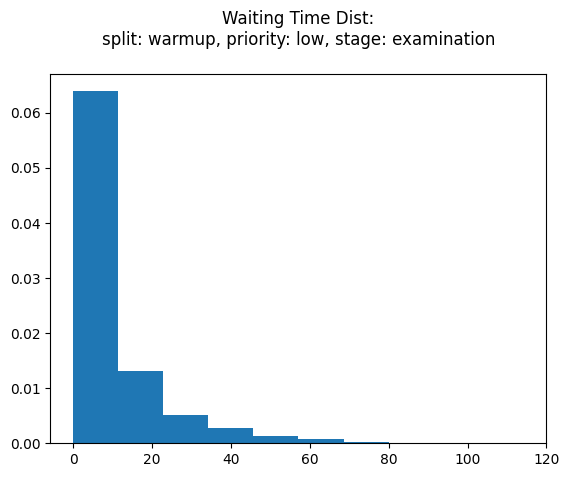

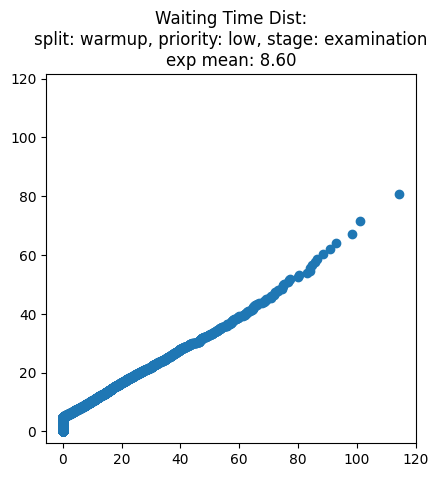

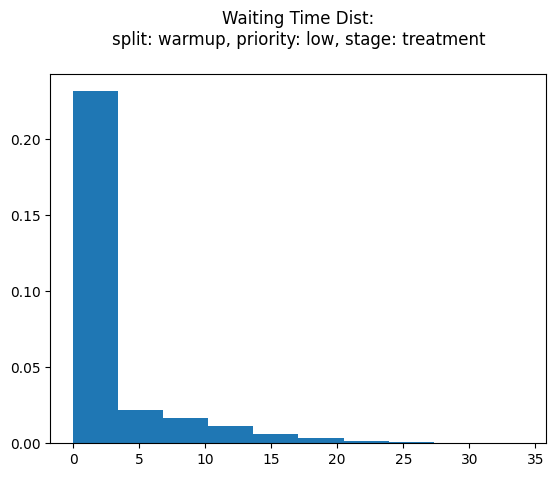

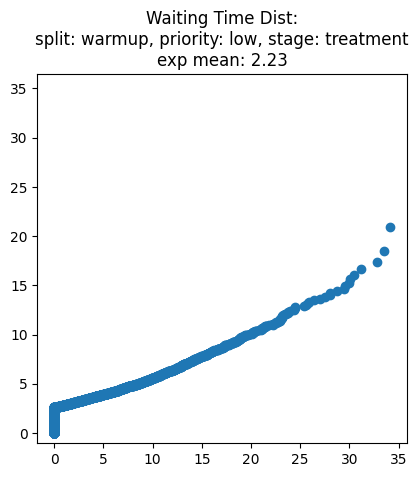

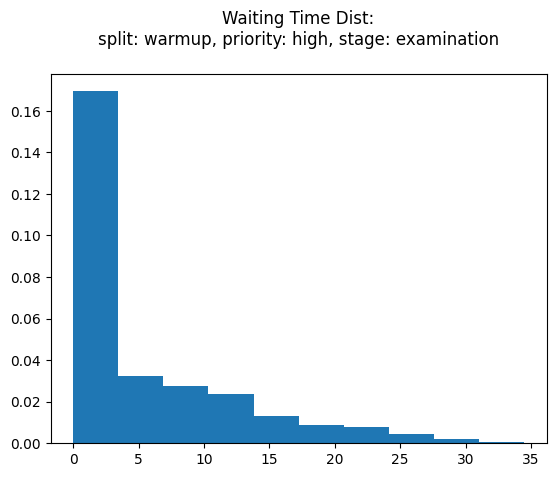

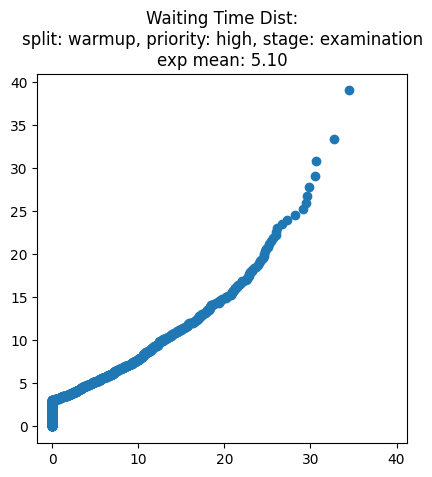

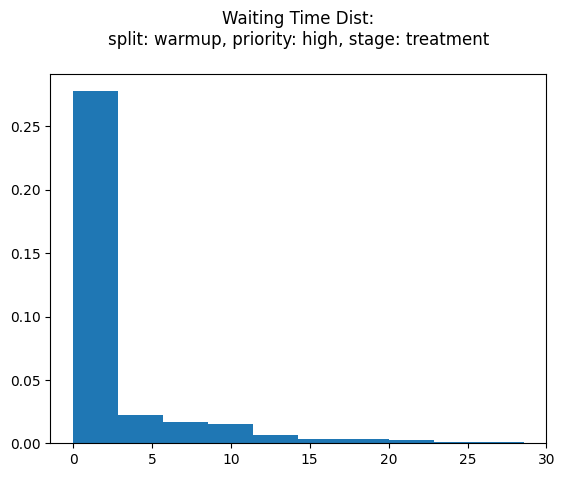

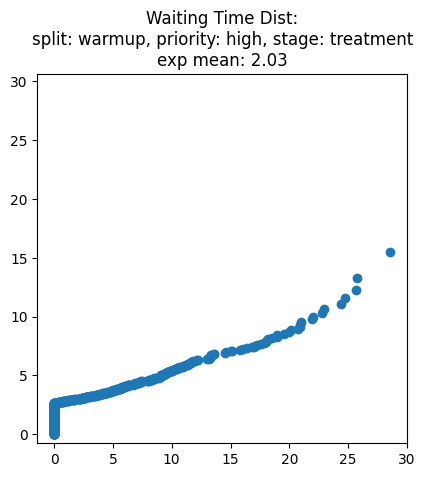

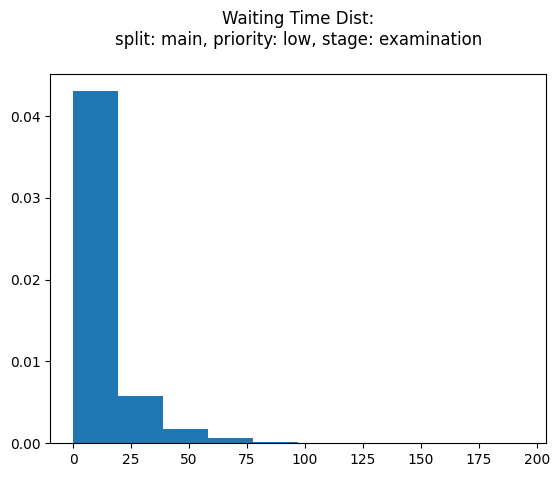

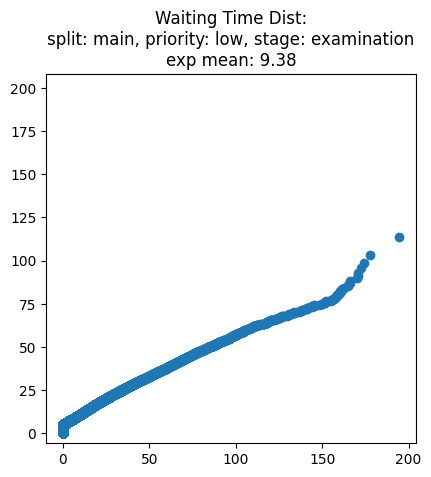

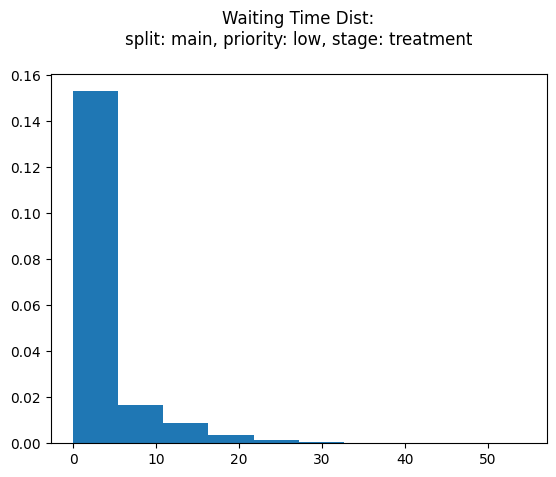

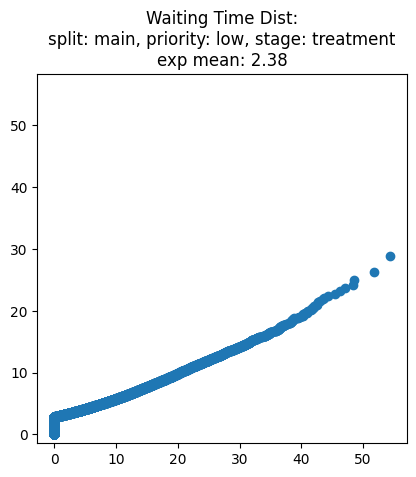

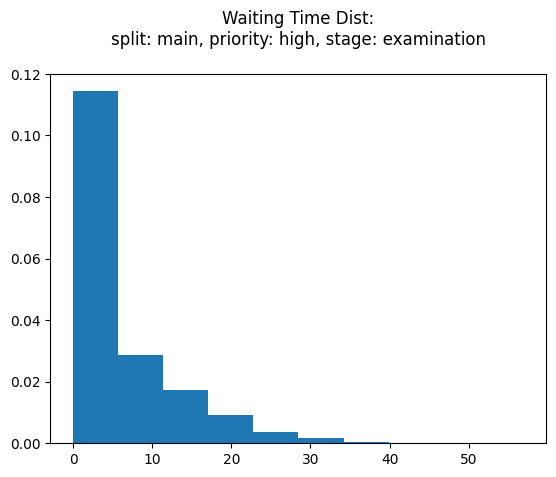

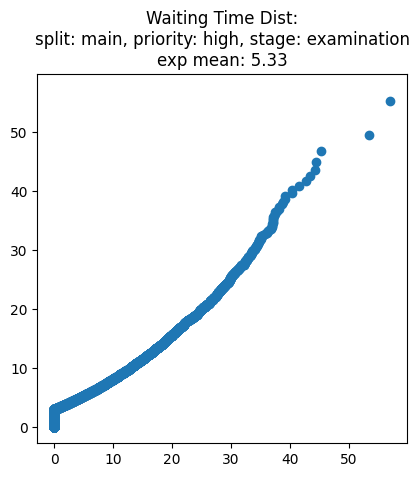

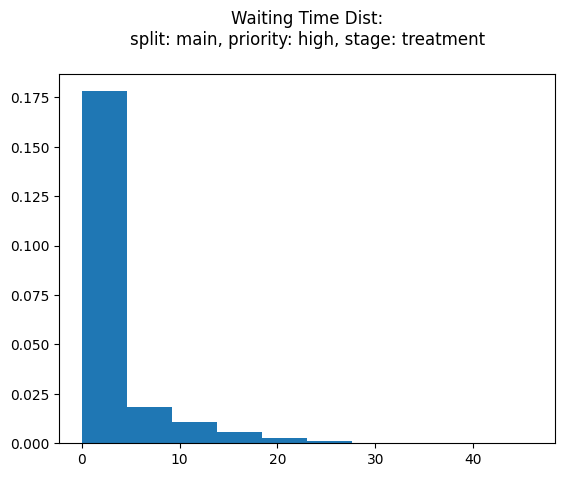

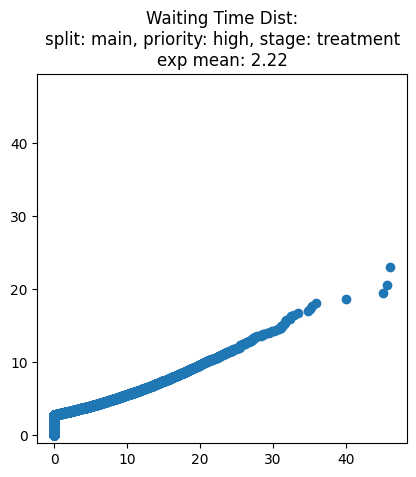

In [19]:
for split in SPLITS:
    for priority in PRIORITIES:
        for stage in STAGES:
            durations = waitingDurations[split][priority][stage]

            plt.figure()

            plt.title(
                f"Waiting Time Dist:\n"
                f"split: {split}, priority: {priority}, stage: {stage}\n"
            )

            plt.hist(durations, density=True)
            plt.show()

            n = len(durations)
            mean = sum(durations) / n
            quantiles = [-mean * math.log(1 - (i + 0.5) / n) for i in range(n)]

            plt.figure()

            plt.title(
                f"Waiting Time Dist:\n"
                f"split: {split}, priority: {priority}, stage: {stage}\n"
                f"exp mean: {np.mean(durations):.2f}"
            )

            plt.scatter(sorted(durations), quantiles)
            plt.axis("square")
            plt.show()

## Optimal Number of Doctors

In [20]:
allResults = []

for examinersCount in range(1, 4):
    for physiciansCount in range(1, 4):
        avgWaits = []
        avgUtils = []

        for i in range(RUNS):
            controller = HospitalController(examinersCount, physiciansCount)
            results = HospitalController(examinersCount, physiciansCount).simulate()

            avgWait = results["main"]["avgWait%"]

            avgUtil = (
                examinersCount * results["main"]["avgUtil%_exam"]
                + physiciansCount * results["main"]["avgUtil%_phys"]
            ) / (examinersCount + physiciansCount)

            avgWaits.append(avgWait)
            avgUtils.append(avgUtil)

        allResults.append(
            (
                examinersCount,
                physiciansCount,
                sum(avgUtils) / len(avgUtils),
                sum(avgWaits) / len(avgWaits),
            )
        )

allResults = pd.DataFrame(
    allResults,
    columns=[
        "examinersCount",
        "physiciansCount",
        "avgUtil%",
        "avgWait%",
    ],
).set_index(["examinersCount", "physiciansCount"])

allResults

avgUtil%  avgWait%
examinersCount physiciansCount                    
1              1                0.685662  0.281588
               2                0.458383  0.232232
               3                0.343668  0.237253
2              1                0.457599  0.083862
               2                0.343352  0.002351
               3                0.274861  0.000890
3              1                0.343778  0.084060
               2                0.274839  0.001564
               3                0.229239  0.000007

In [21]:
optimalNumbersOfDoctors = []


def getScore(alpha: float) -> pd.Series:
    scores = alpha * allResults["avgUtil%"] + (1 - alpha) * (1 - allResults["avgWait%"])

    return scores


for i in range(1, 1000):
    alpha = i / 1000
    scores = getScore(alpha)

    if i % 200 == 0:
        allResults[f"Score (alpha={alpha})"] = scores

    optimalNumbersOfDoctors.append((alpha, *scores.idxmax()))

allResults

avgUtil%  avgWait%  Score (alpha=0.2)  \
examinersCount physiciansCount                                          
1              1                0.685662  0.281588           0.711862   
               2                0.458383  0.232232           0.705891   
               3                0.343668  0.237253           0.678931   
2              1                0.457599  0.083862           0.824430   
               2                0.343352  0.002351           0.866790   
               3                0.274861  0.000890           0.854260   
3              1                0.343778  0.084060           0.801508   
               2                0.274839  0.001564           0.853716   
               3                0.229239  0.000007           0.845842   

                                Score (alpha=0.4)  Score (alpha=0.6)  \
examinersCount physiciansCount                                         
1              1                         0.705312           0.698762   
               2                         0.644014           0.582137   
               3                         0.595116           0.511300   
2              1                         0.732722           0.641015   
               2                         0.735930           0.605071   
               3                         0.709410           0.564561   
3              1                         0.687075           0.572643   
               2                         0.708997           0.564278   
               3                         0.691691           0.537541   

                                Score (alpha=0.8)  
examinersCount physiciansCount                     
1              1                         0.692212  
               2                         0.520260  
               3                         0.427484  
2              1                         0.549307  
               2                         0.474211  
               3                         0.419711  
3              1                         0.458210  
               2                         0.419558  
               3                         0.383390

In [22]:
optimalNumbersOfDoctorsDf = pd.DataFrame(
    optimalNumbersOfDoctors,
    columns=[
        "alpha",
        "examinersCount",
        "physiciansCount",
    ],
).set_index("alpha")

optimalNumbersOfDoctorsDf

,examinersCount,physiciansCount
alpha,,
0.001,3,3
0.002,3,3
0.003,3,3
0.004,3,3
0.005,3,3
...,...,...
0.995,1,1
0.996,1,1
0.997,1,1


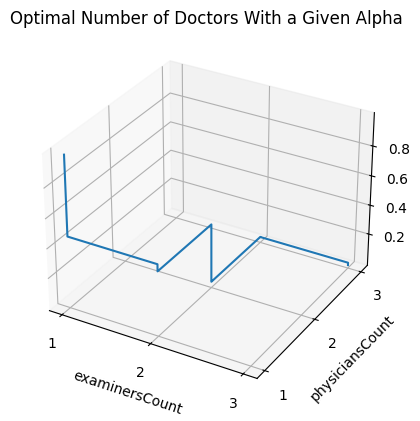

In [23]:
fig = plt.figure()
ax = plt.axes(projection="3d")

ax.set_xticks(list(range(4)))
ax.set_yticks(list(range(4)))

ax.set_xlabel("examinersCount")
ax.set_ylabel("physiciansCount")

ax.plot3D(
    optimalNumbersOfDoctorsDf["examinersCount"],
    optimalNumbersOfDoctorsDf["physiciansCount"],
    optimalNumbersOfDoctorsDf.index,
)

ax.set_title("Optimal Number of Doctors With a Given Alpha")

plt.show()